<a href="https://colab.research.google.com/github/elliedevault/NEUR3002Project/blob/main/Neuroscience_3002_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Group 5 Project 1 Final Submission**
###*Pranav, Jason, Ashley, Aizzah, Tushar, Ellie, Emma*

## 2. Three Models (I&F, Hodgkin-Huxley, and Open-Loop)

### Model 1: Integrate and Fire Model

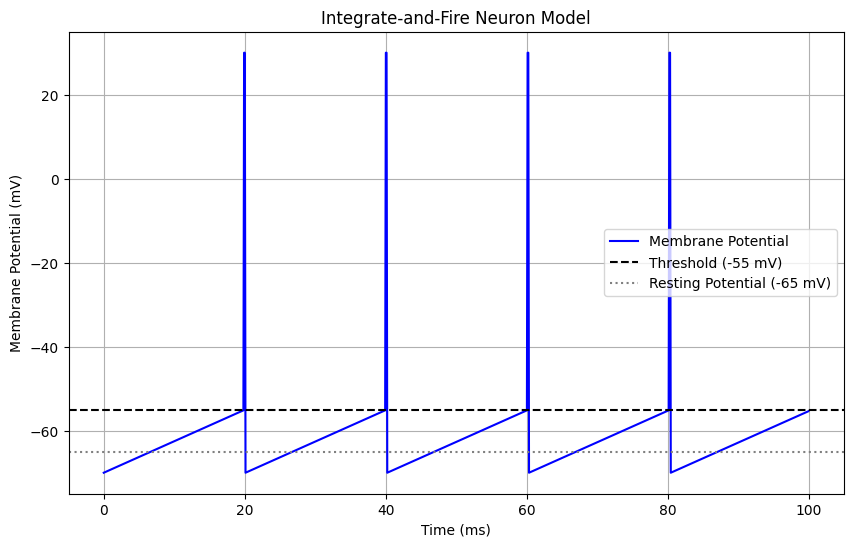

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
V_rest = -70.0      # resting potential (mV)
V_threshold = -55.0 # threshold potential (mV)
V_spike = 30.0      # spike potential (mV)
V_reset = -70.0     # reset potential (mV)
ramp_time = 20.0    # time to reach threshold (ms)
spike_interval = 30 # total cycle time (ms)
dt = 0.1            # simulation time step (ms)
t_total = 100       # total simulation time (ms)

# Initialize time and voltage arrays
time = np.arange(0, t_total, dt)
V = np.zeros(len(time))
V[0] = V_rest

# Simulation with spiking and linear depolarization
for t in range(1, len(time)):
    cycle_time = (t * dt) % spike_interval  # Time within each cycle

    if V[t-1] < V_threshold:  # Linear depolarization phase until threshold
        slope = (V_threshold - V_rest) / ramp_time  # Constant rate of increase
        V[t] = V[t - 1] + slope * dt  # Linear increase

    if V[t] >= V_threshold:  # Once threshold is crossed, spike immediately
        V[t] = V_spike  # Jump to spike value
        V[t-1] = V_spike  # Ensure the previous time step also jumps to spike value
        # After the spike, reset to resting potential
        if t + 1 < len(time):  # Avoid index error at the end of the array
            V[t+1] = V_rest

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, V, 'b-', label='Membrane Potential')
plt.axhline(-55, color='k', linestyle='--', label='Threshold (-55 mV)')
plt.axhline(-65, color='gray', linestyle=':', label='Resting Potential (-65 mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Integrate-and-Fire Neuron Model')
plt.legend()
plt.grid(True)
plt.show()

### Model #2: Hodgkin-Huxley

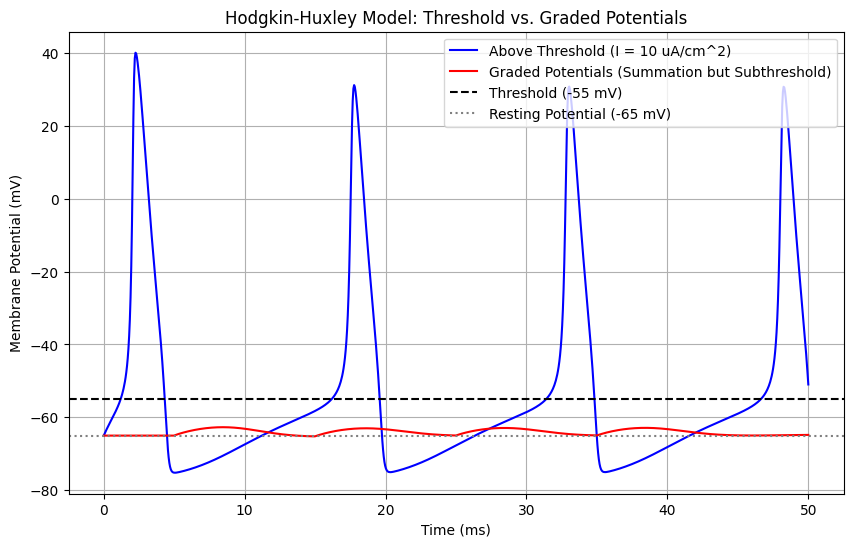

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Hodgkin-Huxley model parameters
gNa = 120  # Maximum conductance of Na+ (mS/cm^2)
gK = 36    # Maximum conductance of K+ (mS/cm^2)
gL = 0.3   # Leak conductance (mS/cm^2)
ENa = 50   # Na+ equilibrium potential (mV)
EK = -77   # K+ equilibrium potential (mV)
EL = -54.4 # Leak equilibrium potential (mV)
Cm = 1.0   # Membrane capacitance (uF/cm^2)

# Define gating variable functions
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)

# Hodgkin-Huxley equations
def hh_model(Y, t, I_func, t_values):
    V, m, h, n = Y
    I = np.interp(t, t_values, I_func)  # Ensure the current matches time steps
    dVdt = (I - gNa * m**3 * h * (V - ENa) - gK * n**4 * (V - EK) - gL * (V - EL)) / Cm
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

# Time variables
t = np.linspace(0, 50, 1000)  # 50 ms simulation

# Initial conditions
V0 = -65  # Resting membrane potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
Y0 = [V0, m0, h0, n0]

# Input currents for threshold vs. graded potentials
I_threshold = np.full_like(t, 9)  # Adjusted to maintain consistent AP height  # Constant input for action potential
I_epsp = np.zeros_like(t)
for spike_time in np.arange(5, 45, 10):  # EPSPs at intervals
    I_epsp += 1.5 * np.exp(-0.1 * (t - spike_time)) * (t > spike_time)  # EPSPs decay over time and do not reach threshold  # Graded potentials oscillating every cycle

# Solve ODEs for both cases
sol_threshold = odeint(hh_model, Y0, t, args=(I_threshold, t))
sol_graded = odeint(hh_model, Y0, t, args=(I_epsp, t))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol_threshold[:, 0], label='Above Threshold (I = 10 uA/cm^2)', color='b')
plt.plot(t, sol_graded[:, 0], label='Graded Potentials (Summation but Subthreshold)', color='r')
plt.axhline(-55, color='k', linestyle='--', label='Threshold (-55 mV)')
plt.axhline(-65, color='gray', linestyle=':', label='Resting Potential (-65 mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Model: Threshold vs. Graded Potentials')
plt.legend()
plt.grid()
plt.show()

###Model 3: Simple Neural Network (Open-Loop)

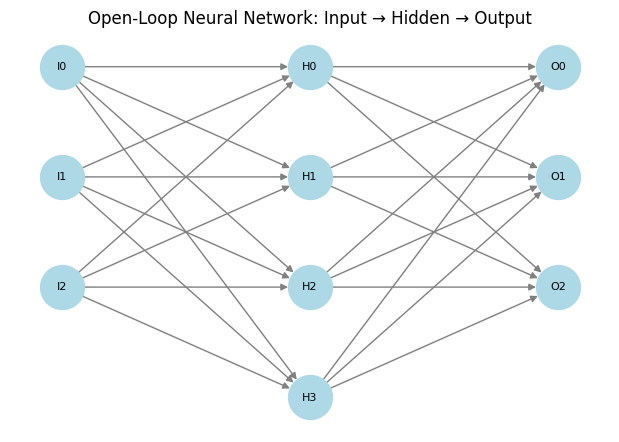

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define a simple feedforward neural network (open-loop)
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def visualize(self):
        G = nx.DiGraph()
        layers = {
            "Input": [f"I{i}" for i in range(self.input_size)],
            "Hidden": [f"H{i}" for i in range(self.hidden_size)],
            "Output": [f"O{i}" for i in range(self.output_size)]
        }

        for layer, nodes in layers.items():
            for node in nodes:
                G.add_node(node, layer=layer)

        for i in layers["Input"]:
            for j in layers["Hidden"]:
                G.add_edge(i, j)
        for i in layers["Hidden"]:
            for j in layers["Output"]:
                G.add_edge(i, j)

        pos = {
            **{node: (0, -i) for i, node in enumerate(layers["Input"])},
            **{node: (1, -i) for i, node in enumerate(layers["Hidden"])},
            **{node: (2, -i) for i, node in enumerate(layers["Output"])}
        }

        plt.figure(figsize=(6, 4))
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=8)
        plt.title("Open-Loop Neural Network: Input → Hidden → Output")
        plt.show()

# Example usage
input_size = 3  # Reduced for simplicity
hidden_size = 4
output_size = 3

model = SimpleNeuralNetwork(input_size, hidden_size, output_size)
model.visualize()


##3. IF, HH Model and Open-Loop Definitions and Comparisons

**Integrate & Fire (IF) Model:** An IF model contains and integrator and a spike generator. As current is injected into the system, the integrator sums the inputs and the spike generator creates the spike with the certain voltage, leading to the output. This is where it is determined if the voltage surpasses the threshold or not to create and action potential or not. Compared to biological neurons, it doesn't take into account the leaky ion channels/natural current leakage and the voltage-gated ion channels. Therefore, there is a "harsh" reset to resting potential once the AP is fired. There is also a linear relationship between voltage over time due to the injected current not leaking out of pores.


**Hodgkin Huxley (HH) Model:** The Hodgkin Huxley (HH) model is more complex then both the I&F and the LIF models. This is because the HH model incorporates voltage-gated ion channels including sodium and potassium. This makes the model more complicated but also more realistic. Therefore, instead of a spike generator deciding on whether AP are generated, the ion channels play a role in deciding on the output. As a result, the voltage over time is non-linear, and there exists hyperpolarization due to the involvement of the K+ channels for example. However, it doesn't take into account the slight variations of ion channels amongst various regions and types of neurons.


**Open-Loop Model:**

**Relation to information theory:**
A bit is a basic unit of information representing two possible states, such as 0 and 1. Shannon's entropy is the amount of uncertainty involved in the value of a random variable or processes. Information theory explains how information can be quantified, stored and communicated. A bit is used to quantify information that distinguishes between two equally likely outcomes while Shannon's entropy describes how many bits are required as more bits will be required for systems with higher uncertainty.

The Hodgkin-Huxley model has more bits because it has more parameters or the inputs require further computation and evaluation.

The Hodgkin-Huxley model has a higher Shannon entropy because it has higher complexity, resulting in greater uncertainty. This is due to the increased variability in the structures that can the change membrane potential such as ion channels. Thus, the action potential firing is not as consistent as the Integrate and Fire model.

## 4. What happens if there are not enough inputs to sum to reach threshold?

*This visualization is already shown in the Hodgkin-Huxley model above.*

**Description of General Changes:**
To update the model, we added code that demonstrate the presence of EPSPs. This first included the time intervals in which they would fire, like every 10 ms from a specific start to end. Furthermore, since they are unable to sum together due to insufficient inputs, we added code in which the EPSPs decay over time and thus do not reach threshold, preventing an action potential from being fired. Lastly, to show this on the graph, we added code to indicate the red line, distinguishing it from the spikes shown in blue generated by sufficient inputs.

**Description of Code and Analysis:**
To implement the changes, the code stating "for spike_time in np.arange(5, 45, 10):" shows the intervals and time period in which the EPSPs are firing, from 5 ms to 45 ms every 10 ms. Then, "I_epsp += 1.5 * np.exp(-0.1 * (t - spike_time)) * (t > spike_time)" shows the graded potentials or depolarizations that do not reach threshold, thus not generating an action potential. This allows the signal to rise below the treshold and decay as a function of time. Lastly, to show the lines on the same graph, we used "plt.plot(t, sol_graded[:, 0], label='Graded Potentials (Summation but Subthreshold)', color='r')" to plot the red line showing the subtreshold inputs.



## 5. What happens if inhibitory inputs are added on to the model?


The code and graph below shows an Hodgkin Huxley model with inhibitory inputs.

**Description of General Changes:** To update the model, we added code that demonstrated the presence of inhibitory inputs on an interval basis. This clearly distinguished when action potential would be fired normally, and how action potential cannot be fired when there are strong inhibitory currents. To do this, we added intervals in which there would be these inputs along with gray shaded bars to clearly denote this on our model.

**Description of Code and Analysis:** To implement these changes, ChatGPT  coded "inhibitory_intervals = [(10, 20), (30, 40)]" to demonstrate when these inhibitory inputs would occur, from the 10-20 second and 30-40 second intervals. Furthermore, to add the inhibitory inputs, ChatGPT added "for start, end in inhibitory_intervals: I_pattern[(t >= start) & (t <= end)] = -3.0" to show the negative current that is injected during these times. This prevented action potentials from occur and caused strong hyperpolarization as shown. To the regular APs, the code was modified to "I_pattern[(t < 10) | ((t > 20) & (t < 30)) | (t > 40)] = 10.0" to show the normal treshold then action potential spikes. Lastly, to clearly illustrate the negative current, "for start, end in inhibitory_intervals: plt.axvspan(start, end, color='gray', alpha=0.3, label='Inhibitory Input' if start == 10 else "")" added those shaded bars during those intervals.


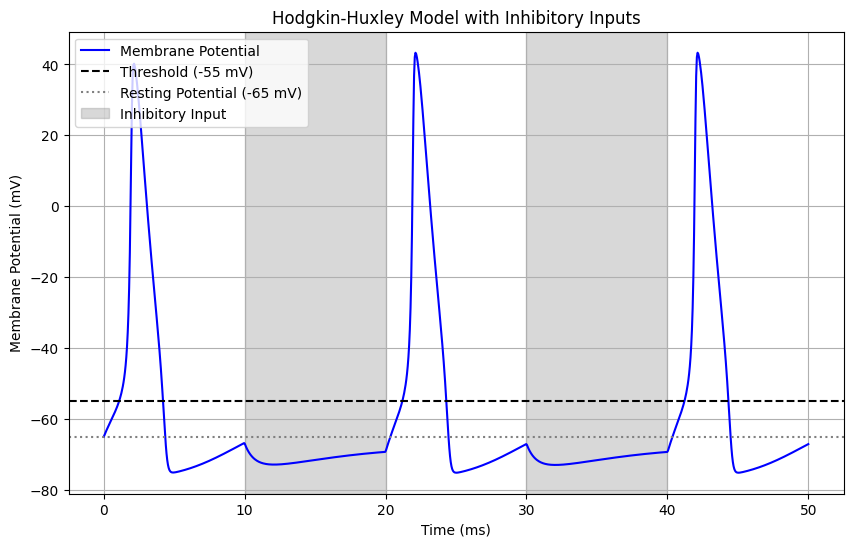

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Hodgkin-Huxley model parameters
gNa = 120  # Maximum conductance of Na+ (mS/cm^2)
gK = 36    # Maximum conductance of K+ (mS/cm^2)
gL = 0.3   # Leak conductance (mS/cm^2)
ENa = 50   # Na+ equilibrium potential (mV)
EK = -77   # K+ equilibrium potential (mV)
EL = -54.4 # Leak equilibrium potential (mV)
Cm = 1.0   # Membrane capacitance (uF/cm^2)

# Define gating variable functions
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)

# Hodgkin-Huxley equations
def hh_model(Y, t, I_func, t_values):
    V, m, h, n = Y
    I = np.interp(t, t_values, I_func)  # Ensure the current matches time steps
    dVdt = (I - gNa * m**3 * h * (V - ENa) - gK * n**4 * (V - EK) - gL * (V - EL)) / Cm
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

# Time variables
t = np.linspace(0, 50, 1000)  # 50 ms simulation

# Initial conditions
V0 = -65  # Resting membrane potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
Y0 = [V0, m0, h0, n0]

# Inhibitory synaptic inputs with alternating inhibitory and excitatory phases
I_pattern = np.zeros_like(t)
inhibitory_intervals = [(10, 20), (30, 40)]  # Inhibition at these intervals
for start, end in inhibitory_intervals:
    I_pattern[(t >= start) & (t <= end)] = -3.0  # Inhibitory inputs

I_pattern[(t < 10) | ((t > 20) & (t < 30)) | (t > 40)] = 10.0  # Excitatory inputs outside inhibition periods

# Solve ODEs
sol_pattern = odeint(hh_model, Y0, t, args=(I_pattern, t))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol_pattern[:, 0], label='Membrane Potential', color='b')
plt.axhline(-55, color='k', linestyle='--', label='Threshold (-55 mV)')
plt.axhline(-65, color='gray', linestyle=':', label='Resting Potential (-65 mV)')

# Shade inhibitory input regions
for start, end in inhibitory_intervals:
    plt.axvspan(start, end, color='gray', alpha=0.3, label='Inhibitory Input' if start == 10 else "")

plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Model with Inhibitory Inputs')
plt.legend()
plt.grid()
plt.show()

## 6.
